# Stationary nonlinear heat transfer

This demo shows how to use a simple `MFront` behaviour to solve a non-linear sationary heat transfer equation with `dolfinx_materials`.

## Description of the non-linear constitutive heat transfer law

The thermal material is described by the following non linear Fourier
Law:

$$
\mathbf{j}=-k\left(T\right)\,\mathbf{\nabla} T
$$

where $\mathbf{j}$ is the heat flux and $\mathbf{\nabla} T$ is the
temperature gradient.

### Expression of the thermal conductivity

The thermal conductivity is assumed to be given by:

$$
k\left(T\right)={\displaystyle \frac{\displaystyle 1}{\displaystyle A+B\,T}}
$$

This expression accounts for the phononic contribution to the thermal
conductivity.

### Derivatives

As discussed below, the consistent linearisation of the heat transfer
equilibrium requires to compute:

-   the derivative
    ${\displaystyle \frac{\displaystyle \partial \mathbf{j}}{\displaystyle \partial \mathbf{\nabla} T}}$
    of the heat flux with respect to the temperature gradient.
    ${\displaystyle \frac{\displaystyle \partial \mathbf{j}}{\displaystyle \partial \mathbf{\nabla} T}}$
    is given by: $$
      {\displaystyle \frac{\displaystyle \partial \mathbf{j}}{\displaystyle \partial \mathbf{\nabla} T}}=-k\left(T\right)\,\matrix{I}
    $$
-   the derivative
    ${\displaystyle \frac{\displaystyle \partial \mathbf{j}}{\displaystyle \partial T}}$
    of the heat flux with respect to the temperature.
    ${\displaystyle \frac{\displaystyle \partial \mathbf{j}}{\displaystyle \partial T}}$
    is given by: $$
      {\displaystyle \frac{\displaystyle \partial \mathbf{j}}{\displaystyle \partial T}}=-{\displaystyle \frac{\displaystyle \partial k\left(T\right)}{\displaystyle \partial T}}\,\mathbf{\nabla} T=B\,k^{2}\,\mathbf{\nabla} T
    $$

## `MFront`’ implementation

### Choice of the the domain specific language

Every `MFront` file is handled by a domain specific language (DSL), which
aims at providing the most suitable abstraction for a particular choice
of behaviour and integration algorithm. See `mfront mfront --list-dsl`
for a list of the available DSLs.

The name of DSL’s handling generic behaviours ends with
`GenericBehaviour`. The first part of a DSL’s name is related to the
integration algorithm used.

In the case of this non linear transfer behaviour, the heat flux is
explicitly computed from the temperature and the temperature gradient.
The `DefaultGenericBehaviour` is the most suitable choice:

``` cpp
@DSL DefaultGenericBehaviour;
```

### Some metadata

The following lines define the name of the behaviour, the name of the
author and the date of its writing:

``` cpp
@Behaviour StationaryHeatTransfer;
@Author Thomas Helfer;
@Date 15/02/2019;
```

### Gradients and fluxes

Generic behaviours relate pairs of gradients and fluxes. Gradients and
fluxes are declared independently but the first declared gradient is
assumed to be conjugated with the first declared fluxes and so on…

The temperature gradient is declared as follows (note that Unicode characters are supported):

``` cpp
@Gradient TemperatureGradient ∇T;
∇T.setGlossaryName("TemperatureGradient");
```

Note that we associated to `∇T` the glossary name `TemperatureGradient`.
This is helpful for the calling code.

After this declaration, the following variables will be defined:

-   The temperature gradient `∇T` at the beginning of the time step.
-   The increment of the temperature gradient `Δ∇T` over the time step.

The heat flux is then declared as follows:

``` cpp
@Flux HeatFlux j;
j.setGlossaryName("HeatFlux");
```

In the following code blocks, `j` will be the heat flux at the end of
the time step.

### Tangent operator blocks

By default, the derivatives of the gradients with respect to the fluxes
are declared. Thus the variable `∂j∕∂Δ∇T` is automatically declared.

However, as discussed in the next section, the consistent linearisation
of the thermal equilibrium requires to return the derivate of the heat
flux with respect to the increment of the temperature (or equivalently
with respect to the temperature at the end of the time step).

``` cpp
@AdditionalTangentOperatorBlock ∂j∕∂ΔT;
```

### Parameters

The `A` and `B` coefficients that appears in the definition of the
thermal conductivity are declared as parameters:

``` cpp
@Parameter real A = 0.0375;
@Parameter real B = 2.165e-4;
```

Parameters are stored globally and can be modified from the calling
solver or from `python` in the case of the coupling with `FEniCS`
discussed below.

### Local variable

A local variable is accessible in each code blocks.

Here, we declare the thermal conductivity `k` as a local variable in
order to be able to compute its value during the behaviour integration
and to reuse this value when computing the tangent operator.

``` cpp
@LocalVariable thermalconductivity k;
```

### Integration of the behaviour

The behaviour integration is straightforward: one starts to compute the
temperature at the end of the time step, then we compute the thermal
conductivity (at the end of the time step) and the heat flux using the
temperature gradient (at the end of the time step).

``` cpp
@Integrator{
  // temperature at the end of the time step
  const auto T_ = T + ΔT;
  // thermal conductivity
  k = 1 / (A + B ⋅ T_);
  // heat flux
  j = -k ⋅ (∇T + Δ∇T);
} // end of @Integrator
```

### Tangent operator

The computation of the tangent operator blocks is equally simple:

``` cpp
@TangentOperator {
  ∂j∕∂Δ∇T = -k ⋅ tmatrix<N, N, real>::Id();
  ∂j∕∂ΔT  =  B ⋅ k ⋅ k ⋅ (∇T + Δ∇T);
} // end of @TangentOperator 
```
## `FEniCSx` implementation

We consider a rectanglar domain with imposed temperatures `Tl` (resp. `Tr`) on the left (resp. right) boundaries. We want to solve for the temperature field `T` inside the domain using a $P^1$-interpolation. We initialize the temperature at value `Tl` throughout the domain.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ufl
from mpi4py import MPI
from dolfinx import fem, mesh
from dolfinx.cpp.nls.petsc import NewtonSolver
from dolfinx_materials.quadrature_map import QuadratureMap
from dolfinx_materials.solvers import NonlinearMaterialProblem
from dolfinx_materials.material.mfront import MFrontMaterial
import os


current_path = os.getcwd()

length = 30e-3
width = 5.4e-3
domain = mesh.create_rectangle(MPI.COMM_WORLD, [(0.0, 0.0), (length, width)], [100, 10])

V = fem.FunctionSpace(domain, ("CG", 1))
T = fem.Function(V, name="Temperature")


def left(x):
    return np.isclose(x[0], 0)


def right(x):
    return np.isclose(x[0], length)


Tl = 300.0
Tr = 800.0
T.vector.set(Tl)

left_dofs = fem.locate_dofs_geometrical(V, left)
right_dofs = fem.locate_dofs_geometrical(V, right)

bcs = [fem.dirichletbc(Tl, left_dofs, V), fem.dirichletbc(Tr, right_dofs, V)]

### Loading the material behaviour

We use the `MFrontMaterial` class for describing the material behaviour. The first argument corresponds to the path where material librairies have been compiled, the second correspond to the name of the behaviour (declared with `@Behaviour`). Finally, the modelling hypothesis is specified (default behaviour is `"3d"`).

In [2]:
material = MFrontMaterial(
    os.path.join(current_path, "src/libBehaviour.so"),
    "StationaryHeatTransfer",
    hypothesis="plane_strain",
)

The `MFront` behaviour declares the field `"TemperatureGradient"` as a Gradient variable, with its associated Flux called `"HeatFlux"`. We can check that the `material` object retrieves `MFront`'s gradient and flux names, as well as the different tangent operator blocks which have been defined, namely `dj_ddgT` and `dj_ddT` in the present case:


In [3]:
print(material.gradients)
print(material.fluxes)

print(["d{}_d{}".format(*t) for t in material.tangent_blocks])

{'TemperatureGradient': 2}
{'HeatFlux': 2}
['dHeatFlux_dTemperatureGradient', 'dHeatFlux_dTemperature']


### Non-linear problem definition

We now define the non-linear residual form that we want to solve. After defining test and trial functions, we instantiate the `QuadratureMap` object which will handle the *black-box* constitutive equation based on the `material` object. We must provide the requested quadrature degree which will control the number of quadrature points used in each cell to compute the non-linear constitutive law. Here, we specify a quadrature of degree 2 (i.e. 3 Gauss points for a triangular element). 

In [4]:
T_ = ufl.TestFunction(V)
dT = ufl.TrialFunction(V)

deg_quad = 2
qmap = QuadratureMap(domain, deg_quad, material)

#### Variable registration

The `MFront` behaviour implicitly declares the temperature as an external state variable called `"Temperature"`. We must therefore associate this external state variable to a known mechanical field. This can be achieved explicitly using the `register_external_state_variable` method. 

For problems in which the temperature only acts as a parameter (no jacobian blocks with respect to the temperature), the temperature can be automatically registered as a constant value ($293.15 \text{ K}$ by default) or to any other (`dolfin.Constant`, `float` or `dolfin.Function`) value using the `register_external_state_variable` method.

Finally, we need to associate to `MFront` gradient object the corresponding UFL expression as a function of the unknown field `T`. To do so, we use the `register_gradient` method linking `MFront` `"TemperatureGradient"` object to the UFL expression `grad(T)`.

In [5]:
qmap.register_external_state_variable("Temperature", T)
qmap.register_gradient("TemperatureGradient", ufl.grad(T))

#### Nonlinear variational formulation

We are now in position of defining the nonlinear variational formulation corresponding to the stationary nonlinear heat transfer. Without any external loading, the nonlinear residual reads as:
\begin{equation}
F(\widehat{T}) = \int_\Omega \mathbf{j}\cdot \nabla \widehat{T} \text{dx} = 0 \quad \forall \widehat{T}
\end{equation}
where the heat flux $\mathbf{j}$ is provided by the `QuadratureMap` as a flux. The latter is a `dolfinx` function defined on `Quadrature` function space (no interpolation is possible). Note that the integration measure must match the chosen quadrature scheme and quadrature degree. It is provided here as `qmap.dx`.

The `qmap.derivative` function works similarly to the standard `ufl.derivative` function except that it will also differentiate the heat flux. From the two tangent operator blocks `dj_ddgT` and `dj_ddT`, it will automatically be deduced that the heat flux $\mathbf{j}$ is a function of both the temperature gradient $\mathbf{g}=\nabla T$ and the temperature itself i.e. $\mathbf{j}=\mathbf{j}(\mathbf{g}, T)$. Hence, the computed Jacobian form will be:

\begin{equation}
J(\widehat{T},T^*) = \int_{\Omega} \nabla \widehat{T}\cdot\left(\dfrac{\partial \mathbf{j}}{\partial \mathbf{g}}\cdot \nabla T^*+\dfrac{\partial \mathbf{j}}{\partial T}\cdot T^*\right) \text{dx}
\end{equation}

The resulting nonlinear problem is managed by the `NonlinearMaterialProblem` class. It is solved using a Newton non-linear solver. The `solve` method returns the converged status and the number of Newton iterations.

In [6]:
j = qmap.fluxes["HeatFlux"]

F = ufl.dot(j, ufl.grad(T_)) * qmap.dx
Jac = qmap.derivative(F, T, dT)

problem = NonlinearMaterialProblem(qmap, F, Jac, T, bcs)

newton = NewtonSolver(MPI.COMM_WORLD)

converged, it = problem.solve(newton)

# Problem is weakly nonlinear, it should converge in a few iterations
assert converged and it < 10

Solution reached in 4 iterations.


We finally check that the thermal conductivity coefficient $k$, computed from the ratio between the horizontal heat flux and temperature gradient matches the temperature-dependent expressions implemented in the `MFront` behaviour.


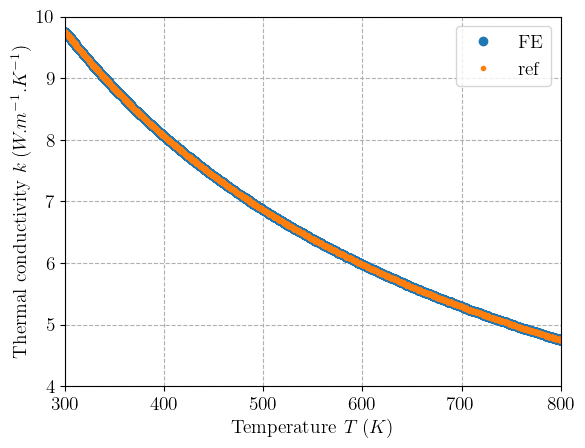

In [7]:
j_vals = j.vector.array
g_vals = qmap.gradients["TemperatureGradient"].function.vector.array
k_gauss = -j_vals[::2] / g_vals[::2]
T_gauss = qmap.external_state_variables["Temperature"].function.vector.array
A = material.get_parameter("A")
B = material.get_parameter("B")
k_ref = 1 / (A + B * T_gauss)
plt.plot(T_gauss, k_gauss, "o", label="FE")
plt.plot(T_gauss, k_ref, ".", label="ref")
plt.xlabel(r"Temperature $T\: (K)$")
plt.ylabel(r"Thermal conductivity $k\: (W.m^{-1}.K^{-1})$")
plt.legend()
plt.show()